In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix, roc_auc_score
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import seaborn as sns

%matplotlib inline


d:\dev\UFC-Predictions\.venv\lib\site-packages\xgboost\compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_csv('../data/preprocessed_data.csv')

In [3]:
df.head()

,Winner,title_bout,no_of_rounds,B_avg_KD,B_avg_opp_KD,B_avg_SIG_STR_pct,B_avg_opp_SIG_STR_pct,B_avg_TD_pct,B_avg_opp_TD_pct,B_avg_SUB_ATT,...,B_Stance_Open Stance,B_Stance_Orthodox,B_Stance_Sideways,B_Stance_Southpaw,B_Stance_Switch,R_Stance_Open Stance,R_Stance_Orthodox,R_Stance_Sideways,R_Stance_Southpaw,R_Stance_Switch
0,Red,False,3,0.570801,0.3125,0.461431,0.504418,0.035756,0.143079,0.578613,...,0,1,0,0,0,0,0,0,0,1
1,Blue,False,3,0.000000,0.7500,0.411250,0.467500,0.000000,0.000000,0.000000,...,0,0,0,0,1,0,1,0,0,0
2,Blue,False,3,0.000000,0.0000,0.560000,0.550000,0.280000,0.000000,1.000000,...,0,1,0,0,0,0,0,0,0,1
3,Red,False,3,0.000000,0.1250,0.220625,0.515000,0.108750,0.250000,0.062500,...,0,1,0,0,0,0,0,0,1,0
4,Red,False,3,0.500000,0.0000,0.590000,0.465000,0.000000,0.500000,0.000000,...,0,0,0,1,0,0,1,0,0,0


### Normalizing data

In [4]:
df_num = df.select_dtypes(include=[float, int])

In [5]:
scaler = StandardScaler()

df[list(df_num.columns)] = scaler.fit_transform(df[list(df_num.columns)])

### Splitting into train, test

In [6]:
y = df['Winner']
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)
label_encoded_y = label_encoder.transform(y)

X = df.drop(columns = 'Winner')

X_train, X_test, y_train, y_test = train_test_split(X, label_encoded_y, test_size=0.1, random_state=41)

### Fitting baseline Xgboost

In [7]:
def plot_confusion(cm):
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    ax.set_ylim([0,2])

    ## Display the visualization of the Confusion Matrix.
    ax.invert_yaxis()
    plt.show()
    

In [8]:
def modelfit(alg, X_train, y_train, X_test, y_test, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train, label=y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
        print(f"Best number of estimators = {cvresult.shape[0]}")
    
    #Fit the algorithm on the data
    alg.fit(np.array(X_train), np.array(y_train), eval_metric='auc')
    
    
    #Predict train set:
    dtrain_predictions = alg.predict(np.array(X_train))
    dtrain_predprob = alg.predict_proba(np.array(X_train))[:,1]
        
    #Predict test set:
    dtest_predictions = alg.predict(np.array(X_test))
    dtest_predprob = alg.predict_proba(np.array(X_test))[:,1]
        
    #Print model report:
    print("\nModel Report: ")
    print(f"Accuracy (Test): {accuracy_score(y_test, dtest_predictions):.4f}")
#     print(f"AUC Score (Train): {roc_auc_score(y_train, dtrain_predprob)}")
    print(f"AUC Score (Test): {roc_auc_score(y_test, dtest_predprob, multi_class='ovo',):.4f}")
    
    
    return dtest_predictions

Best number of estimators = 14

Model Report: 
Accuracy (Test): 0.6871
AUC Score (Test): 0.6973


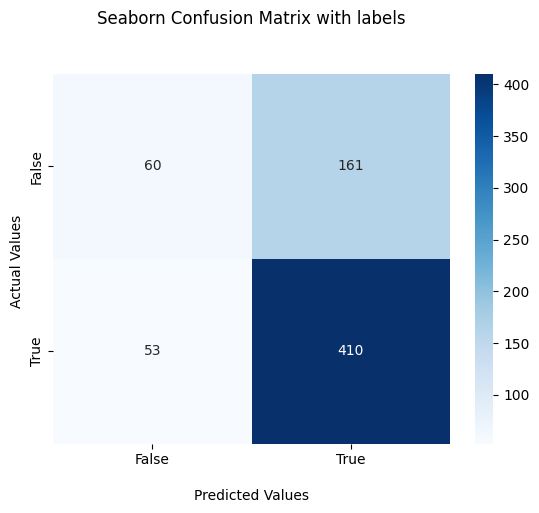

In [9]:
model1 = XGBClassifier(random_state=43, n_jobs=-1)

y1_preds = modelfit(model1, X_train, y_train, X_test, y_test)

cm = confusion_matrix(y_test, y1_preds)

plot_confusion(cm)

In [10]:
feat_imps = {}
for i, imp in enumerate(model1.feature_importances_):
    feat_imps[X_train.columns[i]] = imp

sorted_imp_feats = (sorted(feat_imps.items(), key = lambda x: x[1], reverse=True))
sorted_imp_feats

[('R_age', 0.02163271),
 ('no_of_rounds', 0.021211078),
 ('R_avg_opp_DISTANCE_landed', 0.020303922),
 ('B_avg_SIG_STR_att', 0.019275827),
 ('B_avg_DISTANCE_landed', 0.01741147),
 ('R_Weight_lbs', 0.014139721),
 ('R_avg_opp_SIG_STR_landed', 0.013652795),
 ('B_total_title_bouts', 0.0136253005),
 ('B_age', 0.01362219),
 ('B_Reach_cms', 0.012801797),
 ('R_losses', 0.012264289),
 ('R_win_by_Decision_Split', 0.011505036),
 ('R_avg_opp_HEAD_landed', 0.011214152),
 ('B_avg_opp_TD_landed', 0.0104633225),
 ('R_avg_opp_SIG_STR_pct', 0.010321519),
 ('B_avg_opp_DISTANCE_landed', 0.010275525),
 ('B_avg_opp_LEG_landed', 0.010046323),
 ('R_win_by_Submission', 0.009937628),
 ('B_avg_HEAD_att', 0.009922623),
 ('B_avg_DISTANCE_att', 0.009879798),
 ('R_avg_TOTAL_STR_landed', 0.009808419),
 ('R_avg_SIG_STR_landed', 0.009798393),
 ('B_avg_opp_SUB_ATT', 0.009734296),
 ('B_avg_opp_TOTAL_STR_att', 0.009715623),
 ('B_avg_opp_DISTANCE_att', 0.0095982775),
 ('R_current_lose_streak', 0.0093597565),
 ('B_wins', 0.0

### Since dataset is imbalanced let's try setting scale_pos_weight to see if we get an improvement

Best number of estimators = 100

Model Report: 
Accuracy (Test): 0.6681
AUC Score (Test): 0.6821


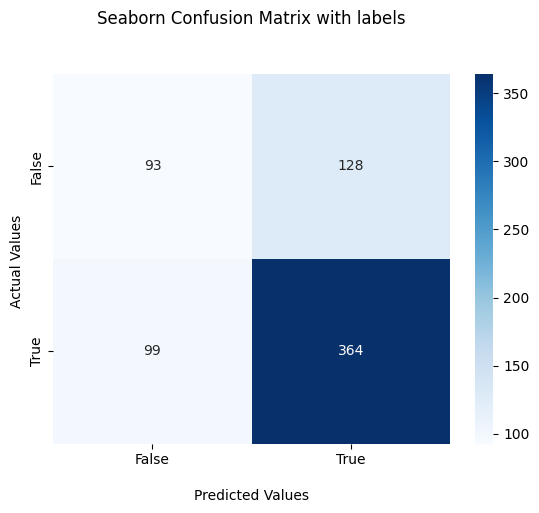

In [11]:
model2 = XGBClassifier(random_state=43, n_jobs=-1, scale_pos_weight=0.7)

y2_preds = modelfit(model2, X_train, y_train, X_test, y_test)

cm = confusion_matrix(y_test, y2_preds)

plot_confusion(cm)

### Hyperparameter tuning 

Best number of estimators = 52

Model Report: 
Accuracy (Test): 0.6696
AUC Score (Test): 0.7051


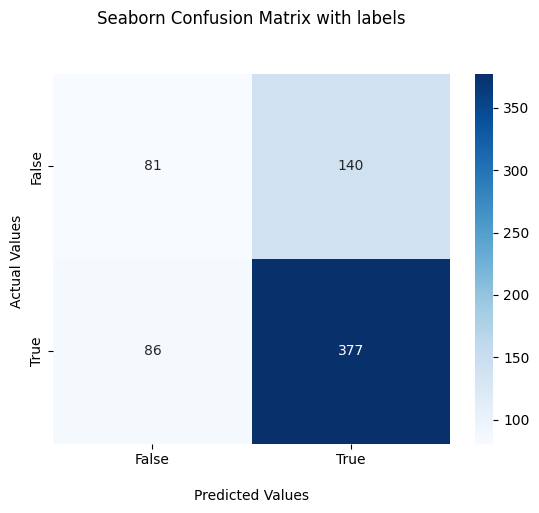

In [12]:
model3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=0.75,
)

y3_preds = modelfit(model3, X_train, y_train, X_test, y_test)

cm = confusion_matrix(y_test, y3_preds)

plot_confusion(cm)

### Oversampling

In [13]:
!pip install --upgrade pip
!pip install imblearn
from imblearn.over_sampling import ADASYN

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [14]:
over_sampler = ADASYN()
X_resampled, y_resampled = over_sampler.fit_resample(X_train, y_train)

In [15]:
pd.Series(y_resampled).value_counts()

0    4241
1    4062
dtype: int64

Best number of estimators = 100

Model Report: 
Accuracy (Test): 0.6637
AUC Score (Test): 0.6870


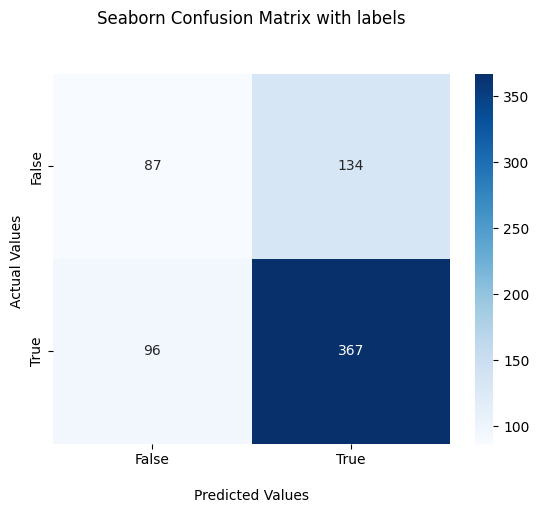

In [16]:
model4 = XGBClassifier(n_jobs=-1, random_state=43)

y4_preds = modelfit(model4, X_resampled, y_resampled, X_test, y_test)

cm = confusion_matrix(y_test, y4_preds)

plot_confusion(cm)

### Hyperparameter tuning for the oversampled data

Best number of estimators = 244

Model Report: 
Accuracy (Test): 0.6696
AUC Score (Test): 0.7019


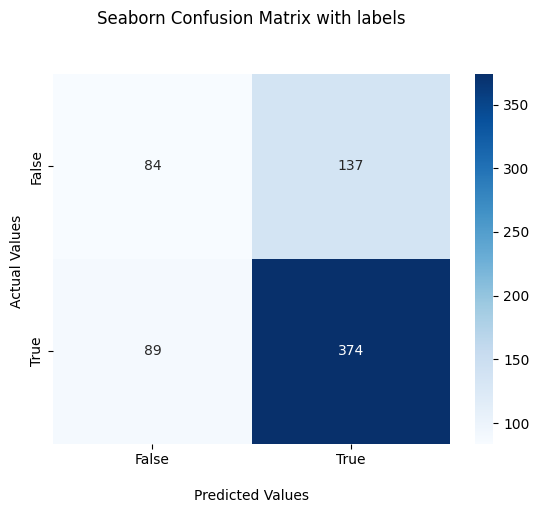

In [17]:
model5 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=244,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
)

y5_preds = modelfit(model5, X_resampled, y_resampled, X_test, y_test)

cm = confusion_matrix(y_test, y5_preds)

plot_confusion(cm)


Model Report: 
Accuracy (Test): 0.6696
AUC Score (Test): 0.6956


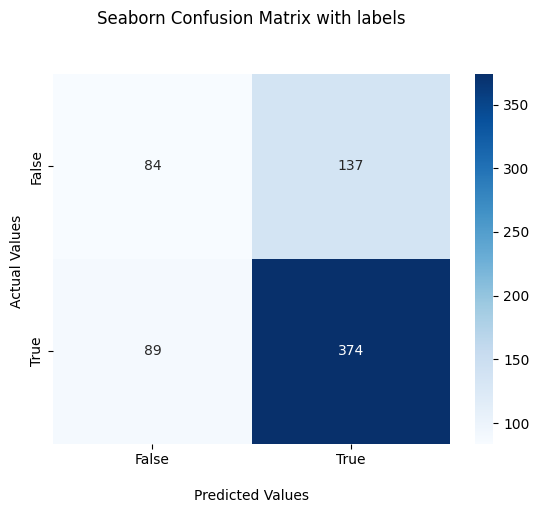

In [18]:
model6 = XGBClassifier(learning_rate =0.1, n_estimators=244, max_depth=4,
                     min_child_weight=1, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
                     objective= 'binary:logistic', reg_alpha= 0, scale_pos_weight=1)

y6_preds = modelfit(model6, X_resampled, y_resampled, X_test, y_test, useTrainCV=False)

cm = confusion_matrix(y_test, y6_preds)

plot_confusion(cm)

In [19]:
X_os, y_os = X_resampled, y_resampled = over_sampler.fit_resample(X, label_encoded_y)

In [20]:
print(classification_report(y_test, y1_preds))

              precision    recall  f1-score   support

           0       0.53      0.27      0.36       221
           1       0.72      0.89      0.79       463

    accuracy                           0.69       684
   macro avg       0.62      0.58      0.58       684
weighted avg       0.66      0.69      0.65       684



In [21]:
print(classification_report(y_test, y2_preds))

              precision    recall  f1-score   support

           0       0.48      0.42      0.45       221
           1       0.74      0.79      0.76       463

    accuracy                           0.67       684
   macro avg       0.61      0.60      0.61       684
weighted avg       0.66      0.67      0.66       684



In [22]:
print(classification_report(y_test, y3_preds))

              precision    recall  f1-score   support

           0       0.49      0.37      0.42       221
           1       0.73      0.81      0.77       463

    accuracy                           0.67       684
   macro avg       0.61      0.59      0.59       684
weighted avg       0.65      0.67      0.66       684



In [23]:
print(classification_report(y_test, y4_preds))

              precision    recall  f1-score   support

           0       0.48      0.39      0.43       221
           1       0.73      0.79      0.76       463

    accuracy                           0.66       684
   macro avg       0.60      0.59      0.60       684
weighted avg       0.65      0.66      0.65       684



In [24]:
print(classification_report(y_test, y5_preds))

              precision    recall  f1-score   support

           0       0.49      0.38      0.43       221
           1       0.73      0.81      0.77       463

    accuracy                           0.67       684
   macro avg       0.61      0.59      0.60       684
weighted avg       0.65      0.67      0.66       684



In [25]:
print(classification_report(y_test, y6_preds))

              precision    recall  f1-score   support

           0       0.49      0.38      0.43       221
           1       0.73      0.81      0.77       463

    accuracy                           0.67       684
   macro avg       0.61      0.59      0.60       684
weighted avg       0.65      0.67      0.66       684



In [26]:
model = model6

model.fit(np.array(X_os), np.array(y_os))

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=244, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method=None, validate_parameters=False, verbosity=None)

In [27]:
with open('../models/model-new.sav', 'wb') as mdl:
    pickle.dump(model, mdl)